In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt




# Datset 


Online Retail K-means & Hierarchical Clustering

link: https://www.kaggle.com/datasets/hellbuoy/online-retail-customer-clustering

In [84]:

primedata = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')

print(primedata.head())    # Data set Load  and print of first five




  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  


Clustering-metrix 

In [85]:
valuesmissing = primedata.isnull().sum() # cheaking missing values 

rowsduplicate = primedata.duplicated().sum() # this code duplicate raw cheaking

print("Missing Values:\n", valuesmissing)
print("Duplicate rows:", rowsduplicate)


Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Duplicate rows: 5268


In [86]:
primeclean = primedata.dropna(subset=['CustomerID'])   # as 5268 raws are missing i drop them

primeclean = primeclean.dropna(subset=['Description']) # 1454 raws are missing 

primeclean = primeclean.drop_duplicates() 

print("Clean data:")
print(primeclean.isnull().sum())                      # check null 
print("Rows of proccess data :", primeclean.shape[0])


Clean data:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64
Rows of proccess data : 401604


In [87]:
primeclean['TotalAmount'] = primeclean['Quantity'] * primeclean['UnitPrice']

primeclean['InvoiceDate'] = pd.to_datetime(primeclean['InvoiceDate'], format='%d-%m-%Y %H:%M') # ensuring datetime formet

recentpurchase = primeclean['InvoiceDate'].max() + pd.Timedelta(days=1) #  RFM -releted to marketing, financial concept , ensuring atleast one day past of purchase 


rfm = primeclean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (recentpurchase - x.max()).days,  # since last purchase day past (within-dictionary)
    'InvoiceNo': 'nunique',  # uniqly identify number of transection - frquency
    'TotalAmount': 'sum'  # Total amount of money customer has spend
}).reset_index()


rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary'] # Rename columns
print(rfm.head())


   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          2      0.00
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [89]:

low_purchasing_power = rfm['Monetary'].min() + (rfm['Monetary'].max() - rfm['Monetary'].min()) * 0.33    #  I segment accordingly to purcashing power theory (corporate finance)
High_purchasing_power = rfm['Monetary'].min() + (rfm['Monetary'].max() - rfm['Monetary'].min()) * 0.66   # calculate there renge and multipy 1/3 as they are three which is approximately .33333 or 33%


def label_customer(monetary_value):
    if monetary_value <= low_purchasing_power:
        return 'Low'
    elif monetary_value <= High_purchasing_power:
        return 'Medium'
    else:
        return 'High'

rfm['Segment'] = rfm['Monetary'].apply(label_customer) # creating the a 'Segment' label

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary Segment
0     12346.0      326          2      0.00     Low
1     12347.0        2          7   4310.00     Low
2     12348.0       75          4   1797.24     Low
3     12349.0       19          1   1757.55     Low
4     12350.0      310          1    334.40     Low


# k-means 

In [91]:
def Kmeans(Data, k, itr=100, show=False):
    np.random.seed(42)
    Centroid_random = np.random.choice(Data.shape[0], k, replace=False) # by seeding ensure that random selection of index won't flactuate 
    Centroids = np.array(Data[Centroid_random])         # assigned the index on on data 
    old_cent = Centroids.copy()                         # Copied the centroid so that it won't change and we will use it for convergence 
    labels = np.zeros(Data.shape[0], dtype=int)         # to store assigned labels
    
    cost = 0                                            # Store the inertia (cost) outside the loop
    for run in range(itr):                              
        Group_ind = []                                  # store the group index come from eucledian distance metrix
        inert = 0                # store cost
        for rows in (Data):
            eu_dis = [np.sqrt(np.sum((rows - cent)**2)) for cent in Centroids] # Eucleadian Distance formula
            mindis = np.min(eu_dis)
            inert += mindis**2                      # squred distance (WCSS)          
            Group_ind.append(np.argmin(eu_dis))     # append index value in group list
        
        cost = inert                                      # Store total inertia
        labels[:] = Group_ind                             # Update the labels 

        for mo in range(k):
            points = Data[labels == mo]             # This say if true then index is belongs to that centroids
            if len(points) > 0:                     # if points have value for mo (moving) centroid then will update
                Centroids[mo] = points.mean(axis=0) # axis=0 will consider column of centroid array 
        
        if np.array_equiv(Centroids, old_cent):     # Returns True if input arrays are shape consistent and all elements equal

            break                            

        old_cent = Centroids.copy()

        if show:
            print("Iteration :", run+1 ,"\nCentroids : ", Centroids, "\nCost : ", cost )    

    return Centroids, labels, cost


# k-means++ Implementation



In [93]:
def Kmeansplusplus(Data, k, itr=100, show=False):
    np.random.seed(42)
    Centroid_random = np.random.choice(Data.shape[0], 1, replace=False)   # This randomly generate First centroid index
    Centroids_plus = np.array([Data[Centroid_random[0]]])                        
    old_cent_plus = Centroids_plus.copy()
    labels_plus= np.zeros(Data.shape[0], dtype=int)                # Zero vector Will store labels
    K = k - 1  
    go = 0
    
    while go < K:
        Each_min_distance = []  # this will store minimum distance between point to Centroid
        Total_min_dist = 0  
        
        for d in Data:
            Distance = [np.sum((d - c) ** 2) for c in Centroids_plus] # WCSS mentioned as reserach paper 
            min_distance = min(Distance) # Choosing minumum distance
            Each_min_distance.append(min_distance)
            Total_min_dist += min_distance # summing all minimum distance
        
        Each_min_distance = np.array(Each_min_distance)  # Convert list to np array
        probability = Each_min_distance / Total_min_dist  # Probabilty calculation 
        
        
        Newcentroid_plus = np.random.choice(Data.shape[0], 1, p=probability) # new centroid selection based on probability 
        Centroids_plus = np.vstack([Centroids_plus, Data[Newcentroid_plus]]) #Raw wise stacking new centroids 
        
        go += 1
                                                  # after that Kmeans 
    # KMeans 
    cost_plus = 0
    for run in range(itr):
        Group_ind = []  
        inert = 0  

      
        for rows in (Data):
            eu_dis = [np.sqrt(np.sum((rows - cent)**2)) for cent in Centroids_plus]
            mindis = np.min(eu_dis)
            inert += mindis**2  
            Group_ind.append(np.argmin(eu_dis))  
        cost_plus = inert  # Store cost
        labels_plus[:] = Group_ind                        # assigning the idices

       
        for mo in range(k):
            points = Data[labels_plus == mo]               # update Centroid
            if len(points) > 0:
                Centroids_plus[mo] = points.mean(axis=0)  
        
        if np.array_equiv(Centroids_plus, old_cent_plus):  
            break                            


        old_cent_plus = Centroids_plus.copy()

        if show:
            print("Iteration :", run +1,"\nCentroids : ", Centroids_plus, "\nCost : ", cost_plus )    
    
    return Centroids_plus, labels_plus, cost_plus


# Clustering_metrics.py

In [94]:

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

def distance_matrix(x, distfunc=euclidean_distance):  # compute pairwise distance
    D_mat = np.zeros((x.shape[0], x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            D_mat[i,j] = distfunc(x[i,], x[j,])
    return D_mat

def dunn_index(X, C, c, distfunc=euclidean_distance):   
    cluster_separation = distance_matrix(c, distfunc=distfunc)
    np.fill_diagonal(cluster_separation, np.inf)  # I change the current notation (np.infty replaced)
    min_separation_clusters = np.min(cluster_separation)
    
    K = len(C)             # Modified K = c.shape[0] to K = len(C), since the clusters are randomly initialized and prioritize the cluster indices in C.
    D = distance_matrix(X, distfunc=distfunc)  
    cluster_diameter = np.zeros(K)
    
    for k in range(K):
        points_in_cluster = X[C[k]]  
        distances_within_cluster = distance_matrix(points_in_cluster, distfunc=distfunc)
        cluster_diameter[k] = np.max(distances_within_cluster)  
    
    return min_separation_clusters / np.max(cluster_diameter)

def cluster_labels(C, M):
    labels = np.zeros((M))
    K = len(C)
    for k in range(K):
        labels[C[k]] = k
    return labels

def silhouette(X, C, c, distfunc=euclidean_distance):
    M = X.shape[0]
    K = len(C)              # Beacuse of random initialaization i made changes here len(c) give number of cluster 
    D = distance_matrix(X, distfunc=distfunc)
    labels = cluster_labels(C, M)
    
    cohesion = np.zeros(M)
    separation = np.zeros(M)
    silhouette_ind = np.zeros(M)
    
    for i in range(M):
        k = labels[i]
        ind = labels == k
        ind[i] = False  # remove distance from point i to point i (zero)
        distances_same_cluster = D[i, ind]
        cohesion[i] = np.mean(distances_same_cluster)

        separation[i] = np.inf
        for l in range(K):
            if l != k:
                dist = D[i, labels == l]
                distances_other_cluster = np.mean(dist)
                if distances_other_cluster < separation[i]:
                    separation[i] = distances_other_cluster
        silhouette_ind[i] = (separation[i] - cohesion[i]) / np.max([separation[i], cohesion[i]])
    
    return np.mean(silhouette_ind)

def purity(C, external_labels):
    external_labels = np.array(external_labels)
    K = len(C)
    M = len(external_labels)
    labels = cluster_labels(C, M)
        
    summed_vals = 0
    for k in range(K):
        ind = labels == k
        u, counts = np.unique(external_labels[ind], return_counts=True)
        summed_vals += np.max(counts)
    
    return summed_vals / M

def random_projection(X, n_components=2):
    n_features = X.shape[1]
    projection_matrix = np.random.randn(n_features, n_components)  
    projected_data = np.dot(X, projection_matrix)  
    return projected_data


def get_cluster_indices(labels):
    cluster_dict = {}   # dictionary to store cluster indices
    for i, label in enumerate(labels):
        if label not in cluster_dict:
            cluster_dict[label] = []
        cluster_dict[label].append(i)
    return list(cluster_dict.values()) # it returns list of list of the points of data which belongs to the respective clusters



In [97]:
print("RFM Shape :", rfm.shape)
print("Rfm columns : ", rfm.columns)               # to check the column and shape 

RFM Shape : (4372, 5)
Rfm columns :  Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Segment'], dtype='object')


In [98]:
rfm_numerical = rfm[['Recency', 'Frequency', 'Monetary']].values     #conversion to numpy array 
rfm_data = rfm[['Recency', 'Frequency', 'Monetary']]

print(rfm_data.isna().sum())
rfm_data = rfm_data.fillna(0)


Recency      0
Frequency    0
Monetary     0
dtype: int64


In [99]:
print("Raw and column : ",rfm_numerical.shape)


Raw and column :  (4372, 3)


## K-means Elbow

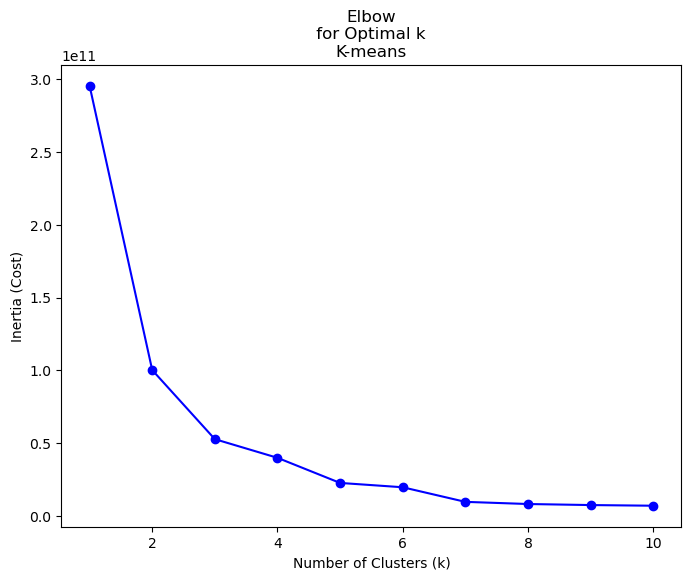

In [ ]:

Inertia = []
RangeK = range(1, 11)  
                                                         #calculating Elbow 
for c in RangeK:
    centroids, labels, cost = Kmeans(rfm_data.values, c)
    Inertia.append(cost)                                 # Store the cost out side the loop


plt.figure(figsize=(8, 6))
plt.plot(RangeK, Inertia, marker='o', color='b')    # Ploting elbow 
plt.title('Elbow\n Optimal k \nK-means')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Cost)')
plt.show()


# K-means run


Iteration : 1 
Centroids :  [[5.08071834e+01 8.53969754e+00 3.58398656e+03]
 [8.69552846e+01 2.08062331e+00 4.02801072e+02]
 [2.13558974e+02 1.34487179e+00 1.28550628e+02]] 
Cost :  298898874319.50714
Iteration : 2 
Centroids :  [[3.11840000e+01 1.42228571e+01 6.99395370e+03]
 [7.83177496e+01 3.33082409e+00 8.01071550e+02]
 [1.82394656e+02 1.37512847e+00 1.40704358e+02]] 
Cost :  277092914813.9717
Iteration : 3 
Centroids :  [[2.08994565e+01 2.21222826e+01 1.28269347e+04]
 [6.20502669e+01 5.01912811e+00 1.40124235e+03]
 [1.45358770e+02 1.57517084e+00 2.32468474e+02]] 
Cost :  259251564052.50092
Iteration : 4 
Centroids :  [[1.64149660e+01 3.38707483e+01 2.43021136e+04]
 [4.77537835e+01 7.16705471e+00 2.22739335e+03]
 [1.26835261e+02 1.95372956e+00 3.50796551e+02]] 
Cost :  235877519763.63525
Iteration : 5 
Centroids :  [[1.10000000e+01 4.78253968e+01 4.40014081e+04]
 [3.92566929e+01 9.54881890e+00 3.21224398e+03]
 [1.15788417e+02 2.31984205e+00 4.69523153e+02]] 
Cost :  200935147348.88

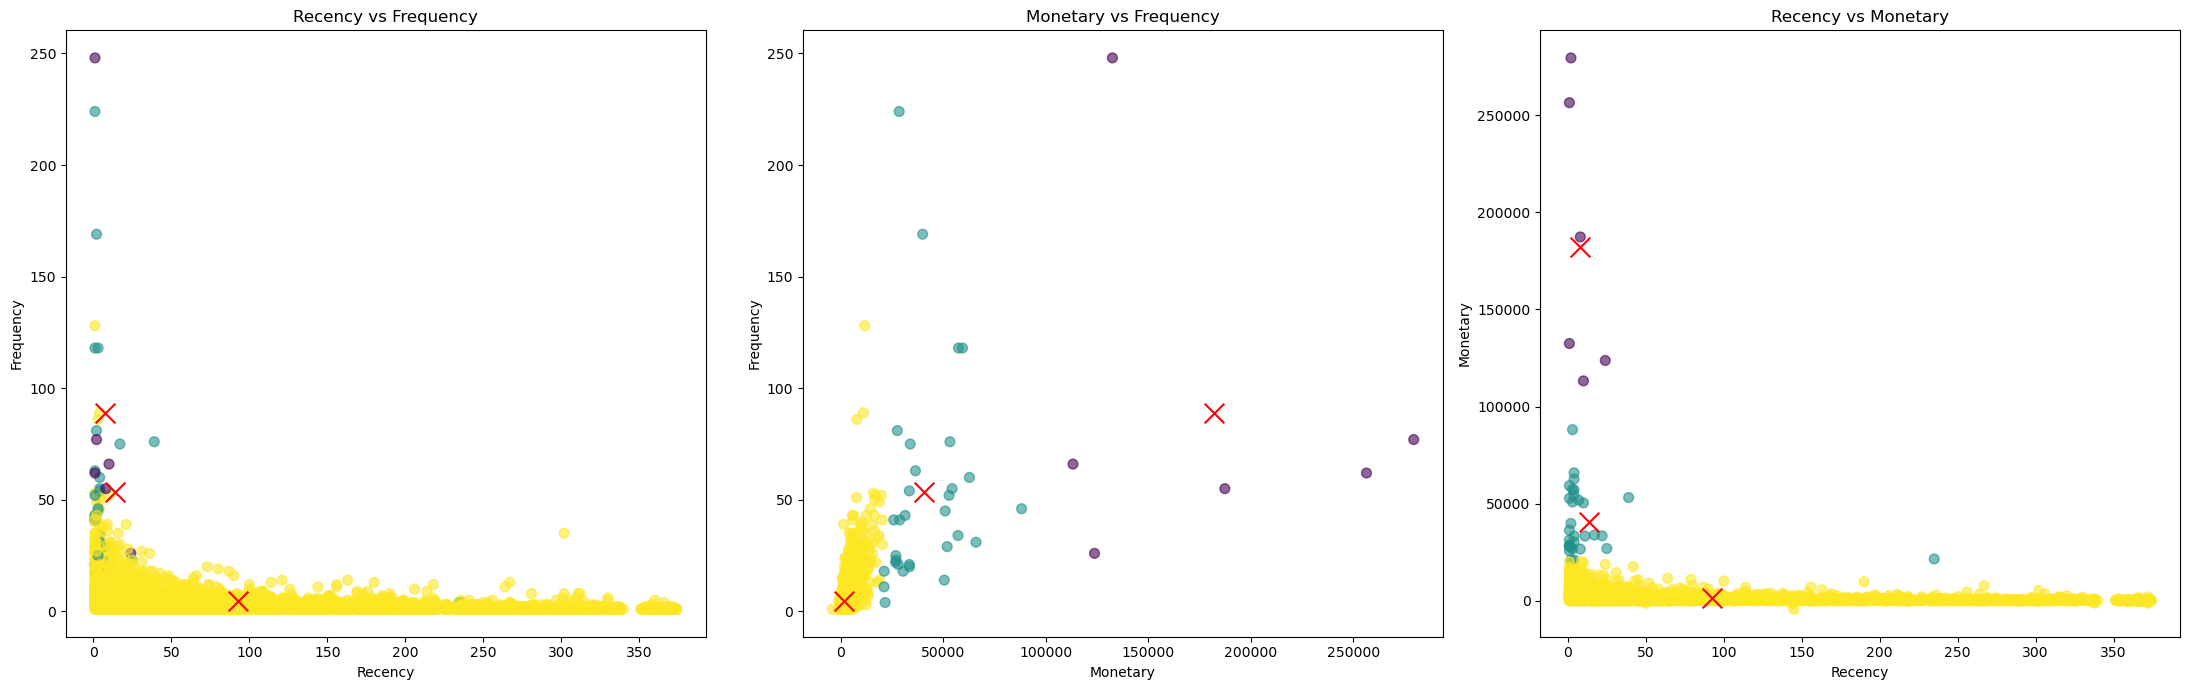

In [66]:
centroids, labels, cost = Kmeans(rfm_numerical, 3, show=True)
rfm['Cluster'] = labels

fig, axes = plt.subplots(1, 3, figsize=(22, 7))  # Adjusted for three plots

# Recency vs Frequency
axes[0].scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')

for i, centroid in enumerate(centroids):                # itration of index and centroid both 
    axes[0].scatter(centroid[0], centroid[1], marker='x', color='red', s=200, label=f'Centroid {i+1}')

# Monetary vs Frequency
axes[1].scatter(rfm['Monetary'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
axes[1].set_xlabel('Monetary')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Monetary vs Frequency')

for i, centroid in enumerate(centroids):
    axes[1].scatter(centroid[2], centroid[1], marker='x', color='red', s=200, label=f'Centroid {i+1}')

# Recency vs Monetary
axes[2].scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Recency vs Monetary')

for i, centroid in enumerate(centroids):
    axes[2].scatter(centroid[0], centroid[2], marker='x', color='red', s=200, label=f'Centroid {i+1}')
    
plt.tight_layout()
plt.show()


In [ ]:
#Recency: Days since last purchase by customer.
#Frequency: Number of purchases made.
#Monetary: Total spending (monitory value).

## K-means++ Elbow

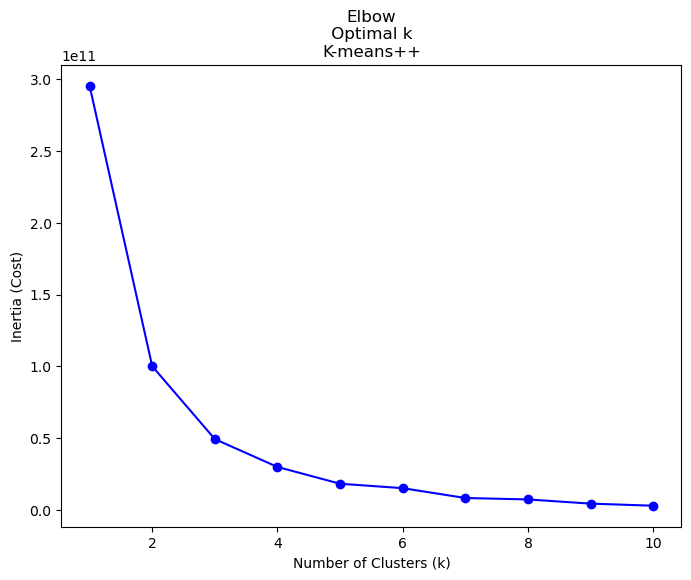

In [82]:

Inertia_plus = []
RangeK = range(1, 11)  #from 1 to 11

for k in RangeK:
    centroids_plus, labels_plus, cost_plus = Kmeansplusplus(rfm_numerical, k=k)

    Inertia_plus.append(cost_plus)  # Store the cost out side the loop

# Ploting elbow
plt.figure(figsize=(8, 6))
plt.plot(RangeK, Inertia_plus, marker='o', color='b')
plt.title('Elbow\n Optimal k \nK-means++')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Cost)')
plt.show()

# K-means++ run

Iteration : 1 
Centroids :  [[9.23980248e+01 4.81809830e+00 1.48878866e+03]
 [3.66666667e+00 6.46666667e+01 2.41083227e+05]
 [7.86666667e+00 6.78666667e+01 7.15389280e+04]] 
Cost :  60343847429.5003
Iteration : 2 
Centroids :  [[9.24187916e+01 4.78038135e+00 1.47997169e+03]
 [3.66666667e+00 6.46666667e+01 2.41083227e+05]
 [7.50000000e+00 7.41875000e+01 6.95595606e+04]] 
Cost :  49716660647.35987
Iteration : 3 
Centroids :  [[9.24397978e+01 4.76700368e+00 1.47195862e+03]
 [3.66666667e+00 6.46666667e+01 2.41083227e+05]
 [7.11764706e+00 7.35294118e+01 6.76062259e+04]] 
Cost :  49540188963.41029


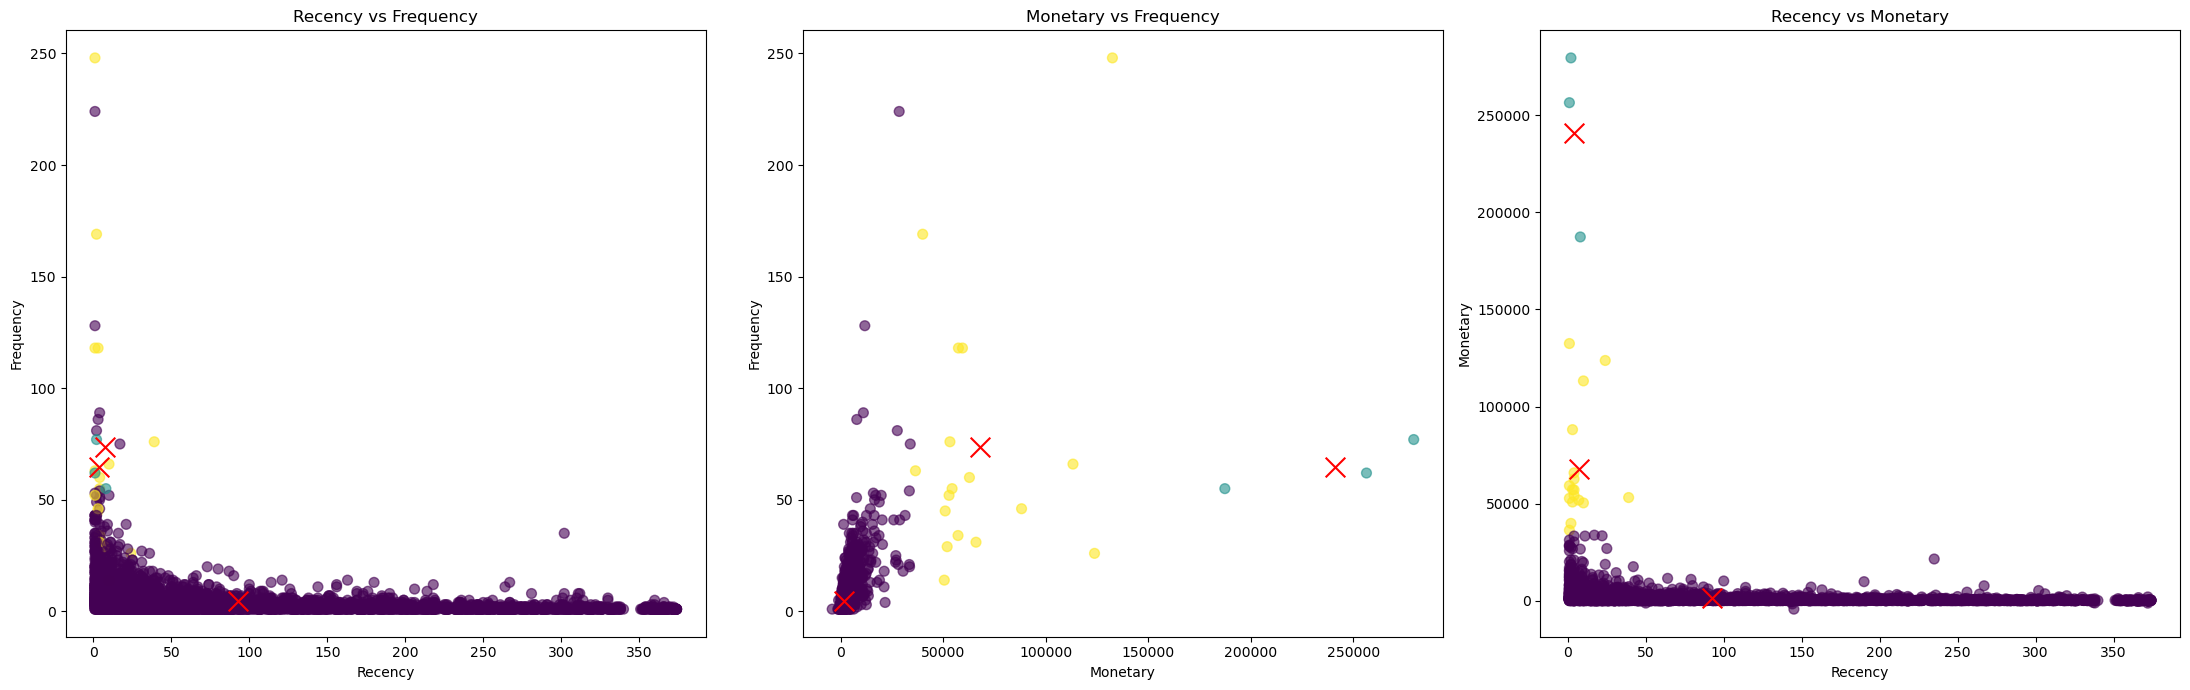

In [100]:
centroids_plus, labels_plus, cost_ = Kmeansplusplus(rfm_numerical, 3, show=True)

rfm['Cluster'] = labels_plus  # Assign cluster labels

# Three subplots (Recency vs Frequency, Monetary vs Frequency, Recency vs Monetary)
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Recency vs Frequency plot
axes[0].scatter(rfm['Recency'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')

for i, centroid in enumerate(centroids_plus):
    axes[0].scatter(centroid[0], centroid[1], marker='x', color='red', s=200, label=f'Centroid {i+1}')

# Monetary vs Frequency plot
axes[1].scatter(rfm['Monetary'], rfm['Frequency'], c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
axes[1].set_xlabel('Monetary')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Monetary vs Frequency')

for i, centroid in enumerate(centroids_plus):
    axes[1].scatter(centroid[2], centroid[1], marker='x', color='red', s=200, label=f'Centroid {i+1}')


# Recency vs Monetary plot
axes[2].scatter(rfm['Recency'], rfm['Monetary'], c=rfm['Cluster'], cmap='viridis', s=50, alpha=0.6)
axes[2].set_xlabel('Recency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Recency vs Monetary')

for i, centroid in enumerate(centroids_plus):
    axes[2].scatter(centroid[0], centroid[2], marker='x', color='red', s=200, label=f'Centroid {i+1}')

plt.tight_layout()
plt.show()


In [80]:
#Recency: Days since last purchase by customer.
#Frequency: Number of purchases made.
#Monetary: Total spending (monitory value).

In [81]:
print("                       Test of the kmeans algorithem                         ")
print("kmeans")
centroids, labels, cost=Kmeans(rfm_numerical, 3,show= False)
rfm['Cluster'] = labels
# Get the cluster indices for K-means
C = get_cluster_indices(labels)  # Get the cluster indices for K-means
# Dunn Index
dunn_score = dunn_index(rfm_data.values, C, centroids)
print("Dunn Index:",dunn_score)
# Silhouette test
sil_score = silhouette(rfm_data.values, C, centroids)
print("Silhouette Score:", sil_score)
# Purity-test
purity_score = purity(C, rfm['Segment'])
print("Purity Score:", purity_score)

print("kmeans++")
centroids_plus, labels_plus, cost_plus=Kmeansplusplus(rfm_numerical, 3, show=False)
rfm['Cluster'] = labels_plus
# Get the cluster indices for K-means
C = get_cluster_indices(labels_plus)  
# Dunn Index
dunn_score = dunn_index(rfm_data.values, C, centroids_plus)
print("Dunn Index:",dunn_score)

# Silhouette test
sil_score = silhouette(rfm_data.values, C, centroids_plus)
print("Silhouette Score:", sil_score)

# Purity-test
purity_score = purity(C, rfm['Segment'])
print("Purity Score:", purity_score)


                       Test of the kmeans algorithem                         
kmeans
Dunn Index: 0.23578150946550427
Silhouette Score: 0.9496195157047782
Purity Score: 0.9993138151875571
kmeans++
Dunn Index: 0.6881394695545053
Silhouette Score: 0.9675290487240273
Purity Score: 0.9993138151875571


In [ ]:
# Last run                             Test of the kmeans algorithem                         
# kmeans
# Dunn Index: 0.23578150946550427
# Silhouette Score: 0.9496195157047782
# Purity Score: 0.9993138151875571
# kmeans++
# Cluster: [0 1 2]
# Dunn Index: 0.6881394695545053
# Silhouette Score: 0.9675290487240273
# Purity Score: 0.9993138151875571

                                         # Result 
# After runing both algorithem i found that kmeans took 50.8s for elbow calculation, 1.4s for clustering.
# While Kmeansplusplus took 12.9s defining the elbow and 0.5s for clustering which is faster, so k-means++ perform faster convergence.
# Kmeansplusplus has cluster compactness and separation, better clustering quality as well.
